In [68]:
import numpy as np
import pulp
import haversine as hs
import matplotlib.pyplot as plt
import sys
# from tqdm.notebook import tqdm

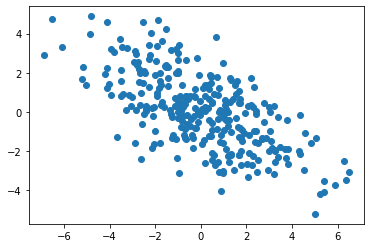

In [69]:
cov = np.array([[6, -3], [-3, 3.5]])
pts = np.random.multivariate_normal([0, 0], cov, size=300)
plt.scatter(pts[:,0], pts[:,1])

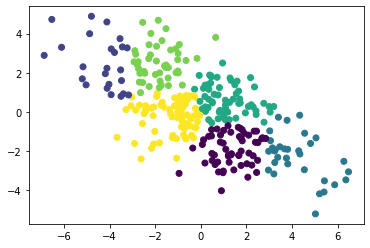

In [70]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, random_state=0).fit(pts)
plt.scatter(pts[:,0], pts[:,1], c=kmeans.labels_)

In [71]:
# function to compute euclidean distance
def distance(p1, p2):
    return np.sum((p1 - p2)**2)
  
# initialization algorithm
def initialize(data, k):
    '''
    initialized the centroids for K-means++
    inputs:
        data - numpy array of data points having shape (200, 2)
        k - number of clusters
    '''
    ## initialize the centroids list and add
    ## a randomly selected data point to the list
    centroids = []
    centroids.append(data[np.random.randint(
            data.shape[0]), :])
  
    ## compute remaining k - 1 centroids
    for c_id in range(k - 1):
         
        ## initialize a list to store distances of data
        ## points from nearest centroid
        dist = []
        for i in range(data.shape[0]):
            point = data[i, :]
            d = sys.maxsize
             
            ## compute distance of 'point' from each of the previously
            ## selected centroid and store the minimum distance
            for j in range(len(centroids)):
                temp_dist = distance(point, centroids[j])
                d = min(d, temp_dist)
            dist.append(d)
             
        ## select data point with maximum distance as our next centroid
        dist = np.array(dist)
        next_centroid = data[np.argmax(dist), :]
        centroids.append(next_centroid)
        dist = []
    return centroids

In [72]:
cluster_size = 6
num_pts = 300
centroids = initialize(pts, k = cluster_size)

problem = pulp.LpProblem("constraint K means", pulp.LpMinimize)
T = [[pulp.LpVariable("T%s,%s"%(i,h), cat="Binary") for h in range(cluster_size)] for i in range(num_pts)]

distance_matrix = np.zeros((num_pts,cluster_size))
for i in range(num_pts):
    for h in range(cluster_size):
        distance_matrix[i,h] = distance(pts[i,:],centroids[h])
        
problem += pulp.lpSum(T[i][h]*distance_matrix[i,h]
                            for h in range(cluster_size) 
                            for i in range(num_pts))

for h in range(cluster_size):
        problem += pulp.lpSum(T[i][h]
                                for i in range(num_pts)) >= 15
        
for i in range(num_pts):
        problem += pulp.lpSum(T[i][h]
                                for h in range(cluster_size)) == 1


problem.solve()

c:\ProgramData\Anaconda3\lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


1

In [73]:
for i in range(20):
    centroids = []
    varsol=[]
    for i in problem.variables():
        if i.varValue==1:
            varsol.append(str(i))
    dict_sol = {}
    for i in range(len(varsol)):
        dict_sol[int(varsol[i].split(",")[0][1:])] = int(varsol[i].split(",")[1])

    for x in set(dict_sol.values()):
        count=0
        idx = []
        for y in dict_sol.keys():
            if dict_sol[y] == x:
                count = count + 1
                idx.append(y)
        centroids.append(np.array(((np.mean(np.array((pts[idx,:])), axis=0)))))
    
    problem = pulp.LpProblem("constraint K means", pulp.LpMinimize)
    T = [[pulp.LpVariable("T%s,%s"%(i,h), cat="Binary") for h in range(cluster_size)] for i in range(num_pts)]

    distance_matrix = np.zeros((num_pts,cluster_size))
    for i in range(num_pts):
        for h in range(cluster_size):
            distance_matrix[i,h] = distance(pts[i,:],centroids[h])
            
    problem += pulp.lpSum(T[i][h]*distance_matrix[i,h]
                                for h in range(cluster_size) 
                                for i in range(num_pts))

    for h in range(cluster_size):
            problem += pulp.lpSum(T[i][h]
                                    for i in range(num_pts)) >= 15
            
    for i in range(num_pts):
            problem += pulp.lpSum(T[i][h]
                                    for h in range(cluster_size)) == 1


    problem.solve()        

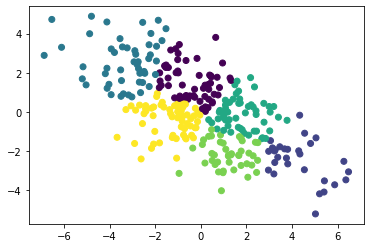

In [74]:
varsol=[]
for i in problem.variables():
    if i.varValue==1:
        varsol.append(str(i))
dict_sol = {}
for i in range(len(varsol)):
    dict_sol[int(varsol[i].split(",")[0][1:])] = int(varsol[i].split(",")[1])
labels =[]
for x in sorted(dict_sol.keys()):
    labels.append(dict_sol[x])
plt.scatter(pts[:,0], pts[:,1], c=labels)